# Exampes with natural images
In this notebook I show several examples with natural images. The rows (and columns) in a natural image form a clear one-dimensional sequence. Therefore, we can shuffle the rows by changing their relative order. Considering each row as a separate 1D object, we can define the shuffled image as the input dataset and apply the Sequencer to it. We can then reorder the rows according to the detected sequence, and to check whether the Sequencer was able to recover the original image. <br>

The images I use in this notebook are taken from the COCO dataset (link: http://cocodataset.org/#home). In particular, I used images from the 2017 validation set. <br> 

The notebook consists of the following parts: <br>
1. **Loading and shuffling a natural image:** this part of the notebook will contain functions that I need to load and shuffle images. <br>
2. **Applying the Sequencer to a set of shuffled images:** in this part of the notebook we will apply the Sequencer to a set of shuffled images, and will check whether the Sequencer is able to recover the original images. <br>
3. **Application of tSNE and UMAP to a shuffled image:** in this part of the notebook I will try to reorder the shuffled images using tSNE and UMAP. I will apply tSNE and UMAP to the shuffled image, and using their one-dimensional embedding, I will reorder the rows to obtain a reconstructed image. Both tSNE and UMAP depend on several hyper-parameters. In the Jupyter notebook `comparison_with_tsne_and_umap.ipynb` in the examples directory, I showed that one can define an elongation of the resulting embedding by tSNE and UMAP, and use it as a figure of merit to optimize the hyper parameters of various dimensionality reduction algorithms. In this part of the notebook I will demonstrate this by examining tSNE/UMAP hyper-parameters, and comparing the elongation of the resulting embeddings.

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [1]:
#!conda install numpy scipy networkx matplotlib scikit-learn
#!pip install umap-learn
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance
import umap
from skimage.io import imread, imshow
from skimage.transform import resize

import sequencer

In [3]:
sequencer?

## 1. Loading and shuffling a natural image
This part of the notebook contains functions that I need to load and shuffle images. The following cell contains a function that takes as an input an image path, loads the image, and shuffles its rows.

In [4]:
def return_shuffled_dataset(image_path):
    """Function loads the image from the input path and down-samples it.
    Function then shuffles the image and returns it.
    """
    # load the image
    data = imread(image_path, as_gray=True)

    # down-sample the image to be 1/3 of its original size
    # this is done to reduce the computation time, users can remove it
    shape_x = int(data.shape[0]*0.3)
    shape_y = int(data.shape[1]*0.3)
    new_shape = (shape_x, shape_y)
    objects_list = resize(data, new_shape) + 1.

    # shuffle the objects in the sample
    random_indices = numpy.arange(len(objects_list))
    numpy.random.shuffle(random_indices)
    objects_list_shuffled = objects_list[random_indices, :]
    
    # x-axis
    grid = numpy.arange(len(objects_list_shuffled[0]))
    
    return random_indices, grid, objects_list, objects_list_shuffled

## 2. Applying the Sequencer to a set of shuffled images
In this part of the notebook I will load the different natural images from the directory and will shuffle them. I will then apply the Sequencer to the shuffled images and check whether the Sequencer was able to recover the original image. 

In [5]:
%ls data_for_examples/images_from_COCO_dataset/

000000000285.jpg  000000085682.jpg  000000249025.jpg  000000458992.jpg
000000012576.jpg  000000098520.jpg  000000287649.jpg  000000544519.jpg
000000032081.jpg  000000170893.jpg  000000374545.jpg  000000570736.jpg
000000065485.jpg  000000210708.jpg  000000414261.jpg


### 000000000285.jpg

In [6]:
image_path = "data_for_examples/images_from_COCO_dataset/000000000285.jpg"

# get the shuffled image
random_indices, grid, objects_list, objects_list_shuffled = return_shuffled_dataset(image_path)
print("shape of the input dataset: ", objects_list_shuffled.shape)

# apply the Sequencer to the shuffled dataset
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_average_N_best_estimators=True, 
                                               number_of_best_estimators=3)

shape of the input dataset:  (192, 175)
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.0994057655334473 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 4.429659128189087 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 7.766959190368652 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 15.798839092254639 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 3.100364923477173 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 4.831383943557739 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished c

/anaconda3/lib/python3.7/site-packages/sequencer/sequencer_.py:945: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>


In [6]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

resulting elongation:  192.0
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 124.76
metric=EMD, scale=2, elongation: 147.13
metric=EMD, scale=4, elongation: 156.84
metric=EMD, scale=8, elongation: 181.26
metric=energy, scale=1, elongation: 128.13
metric=energy, scale=2, elongation: 152.55
metric=energy, scale=4, elongation: 183.45
metric=energy, scale=8, elongation: 115.22
metric=KL, scale=1, elongation: 192.0
metric=KL, scale=2, elongation: 192.0
metric=KL, scale=4, elongation: 192.0
metric=KL, scale=8, elongation: 158.49
metric=L2, scale=1, elongation: 192.0
metric=L2, scale=2, elongation: 192.0
metric=L2, scale=4, elongation: 192.0
metric=L2, scale=8, elongation: 158.49


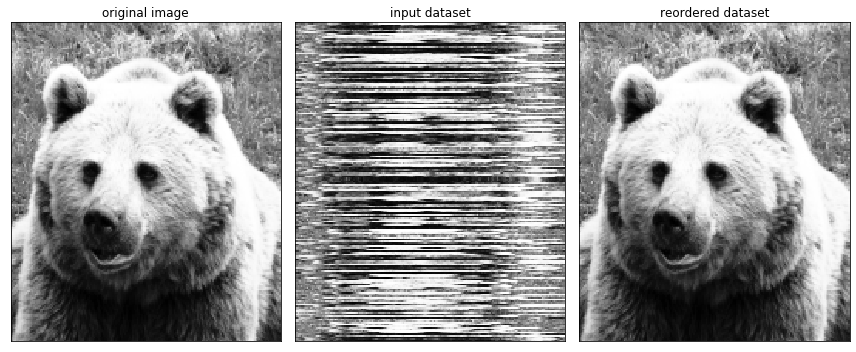

In [7]:
# plot the original dataset, the shuffled input dataset, and the result by the Sequencer

objects_list_reordered = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("original image")
plt.pcolormesh(objects_list[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.title("reordered dataset")
plt.pcolormesh(objects_list_reordered[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.tight_layout()

### 000000012576.jpg

In [8]:
image_path = "data_for_examples/images_from_COCO_dataset/000000012576.jpg"

# get the shuffled image
random_indices, grid, objects_list, objects_list_shuffled = return_shuffled_dataset(image_path)
print("shape of the input dataset: ", objects_list_shuffled.shape)

# apply the Sequencer to the shuffled dataset
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_average_N_best_estimators=True, 
                                               number_of_best_estimators=3)

shape of the input dataset:  (192, 144)
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 2.0464930534362793 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 3.435789108276367 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 6.572669982910156 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 3.026829719543457 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 4.216738939285278 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished calculating this distance matrix list, it took: 8.379361152648926 seconds
calculating the distance matrices for estimator: KL, scale: 1
finished cal

In [9]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

resulting elongation:  74.90364583333333
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 29.69
metric=EMD, scale=2, elongation: 43.14
metric=EMD, scale=4, elongation: 44.1
metric=energy, scale=1, elongation: 31.01
metric=energy, scale=2, elongation: 42.78
metric=energy, scale=4, elongation: 50.56
metric=KL, scale=1, elongation: 78.92
metric=KL, scale=2, elongation: 74.93
metric=KL, scale=4, elongation: 72.03
metric=L2, scale=1, elongation: 70.61
metric=L2, scale=2, elongation: 74.9
metric=L2, scale=4, elongation: 68.02


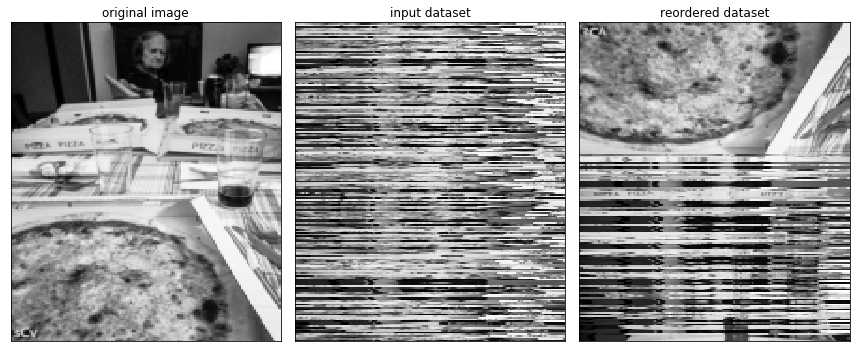

In [10]:
# plot the original dataset, the shuffled input dataset, and the result by the Sequencer

objects_list_reordered = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("original image")
plt.pcolormesh(objects_list[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.title("reordered dataset")
plt.pcolormesh(objects_list_reordered[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.tight_layout()

### 000000032081.jpg

In [11]:
image_path = "data_for_examples/images_from_COCO_dataset/000000032081.jpg"

# get the shuffled image
random_indices, grid, objects_list, objects_list_shuffled = return_shuffled_dataset(image_path)
print("shape of the input dataset: ", objects_list_shuffled.shape)

# apply the Sequencer to the shuffled dataset
estimator_list = ['EMD', 'energy', 'KL', 'L2']
seq = sequencer.Sequencer(grid, objects_list_shuffled, estimator_list)
output_path = "sequencer_output_directory"
final_elongation, final_sequence = seq.execute(output_path, 
                                               to_average_N_best_estimators=True, 
                                               number_of_best_estimators=3)

shape of the input dataset:  (150, 112)
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 1.3014190196990967 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 2.0479238033294678 seconds
calculating the distance matrices for estimator: EMD, scale: 4
finished calculating this distance matrix list, it took: 4.083120822906494 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 1.0740258693695068 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 2.2841358184814453 seconds
calculating the distance matrices for estimator: energy, scale: 4
finished calculating this distance matrix list, it took: 4.097823143005371 seconds
calculating the distance matrices for estimator: KL, scale: 1
finished 

In [12]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

resulting elongation:  39.5344
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 30.8
metric=EMD, scale=2, elongation: 20.84
metric=EMD, scale=4, elongation: 30.51
metric=energy, scale=1, elongation: 48.38
metric=energy, scale=2, elongation: 27.99
metric=energy, scale=4, elongation: 45.49
metric=KL, scale=1, elongation: 35.68
metric=KL, scale=2, elongation: 39.53
metric=KL, scale=4, elongation: 37.04
metric=L2, scale=1, elongation: 36.86
metric=L2, scale=2, elongation: 39.51
metric=L2, scale=4, elongation: 33.65


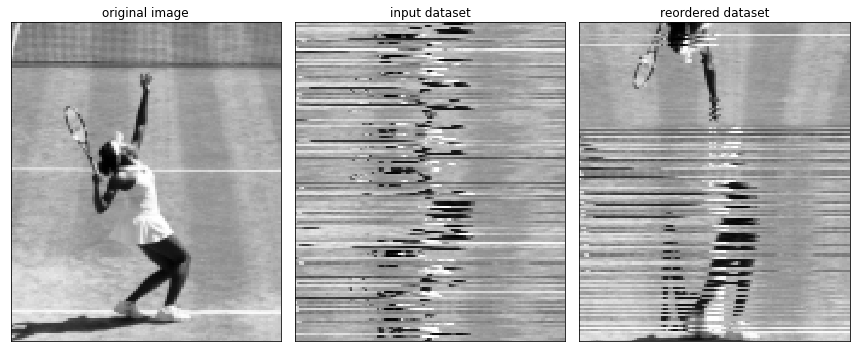

In [13]:
# plot the original dataset, the shuffled input dataset, and the result by the Sequencer

objects_list_reordered = objects_list_shuffled[final_sequence, :]

plt.figure(1, figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("original image")
plt.pcolormesh(objects_list[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.title("input dataset")
plt.pcolormesh(objects_list_shuffled[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.title("reordered dataset")
plt.pcolormesh(objects_list_reordered[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.tight_layout()

### Summary:
I will not continue to show the performance of the Sequencer for all of these images, but users are encouraged to check the different images themselves, by changing the `image_path` parameter. Generally, we see that in some image the Sequencer successfully identifies the one-dimensional trend, while in other cases it struggles.

## 3. Application of tSNE and UMAP to a shuffled image
In this part of the notebook I will select a single natural image, shuffle it, and will try to reorder it using the one-dimensional embedding by tSNE and UMAP. Both tSNE and UMAP depend on several hyper-parameters. In addition, their output strongly depends on the assumed distance metric between the objects in the sample (the rows in the image in our case). In the notebook `comparison_with_tsne_and_umap.ipynb` in the examples directory we showed that one can define an elongation of the resulting embedding, and to use as a figure of merit to optimize the hyper-parameters of the algorithms. To demonstrate this point, I will vary the hyper-parameters by tSNE and UMAP and present the one-dimensional embedding for each choice of hyper-parameters. I will print the derived elongation for each of the choices.

shape of the input dataset:  (192, 164)


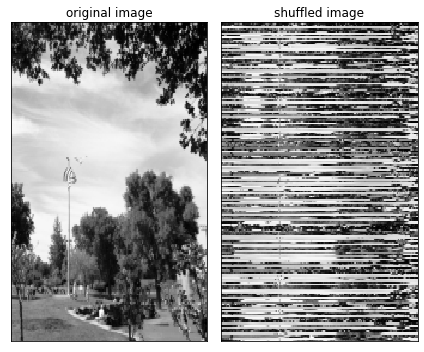

In [14]:
# load a particular image
image_path = "data_for_examples/images_from_COCO_dataset/000000374545.jpg"

# get the shuffled image
random_indices, grid, objects_list, objects_list_shuffled = return_shuffled_dataset(image_path)
print("shape of the input dataset: ", objects_list_shuffled.shape)

plt.figure(1, figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.title("original image")
plt.pcolormesh(objects_list[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.title("shuffled image")
plt.pcolormesh(objects_list_shuffled[::-1], cmap="Greys_r")
plt.xticks([])
plt.yticks([])

plt.tight_layout()

In [15]:
# copy the function that estimates the elongation of the resulting embedding.
# see the notebook: comparison_with_tsne_and_umap.ipynb for additional details.

import sequencer.elongation_estimation as elongation_estimation

def return_elongation_of_2D_embedding(y):
    """Function estimates the elongation of the given two-dimensional embedding. 
    
    Parameters
    -------
    :param y: numpy.ndarray() of shape (N, 2), where N is the number of objects in the sample. 
        This array represents the two-dimensional embedding of the objects in the sample by algorithms
        such as tSNE and UMAP.
        
    Returns
    -------
    :param elongation_normalized: float, the normalized elongation of the two-dimensional embedding
    """
    distance_matrix = numpy.zeros((len(y), len(y)))
    for i in range(len(y)):
        for j in range(len(y)):
            d = numpy.sum((y[i] - y[j])**2)
            distance_matrix[i, j] = d
    
    G, mst_elongation = elongation_estimation.apply_MST_and_return_MST_and_elongation(distance_matrix)
    elongation_normalized = mst_elongation / float(len(y))
    return elongation_normalized

### tSNE
Apply tSNE to the shuffled image. Examine several different choices of hyper-parameters. For each choice, estimate the elongation of the resulting embedding, and print it next to the result. <br>
**Note**: in the following example, I am using only the Euclidean Distance. Users are encoraged to check the EMD as well (see the notebook `comparison_with_tsne_and_umap.ipynd` in the examples directory for additional details)

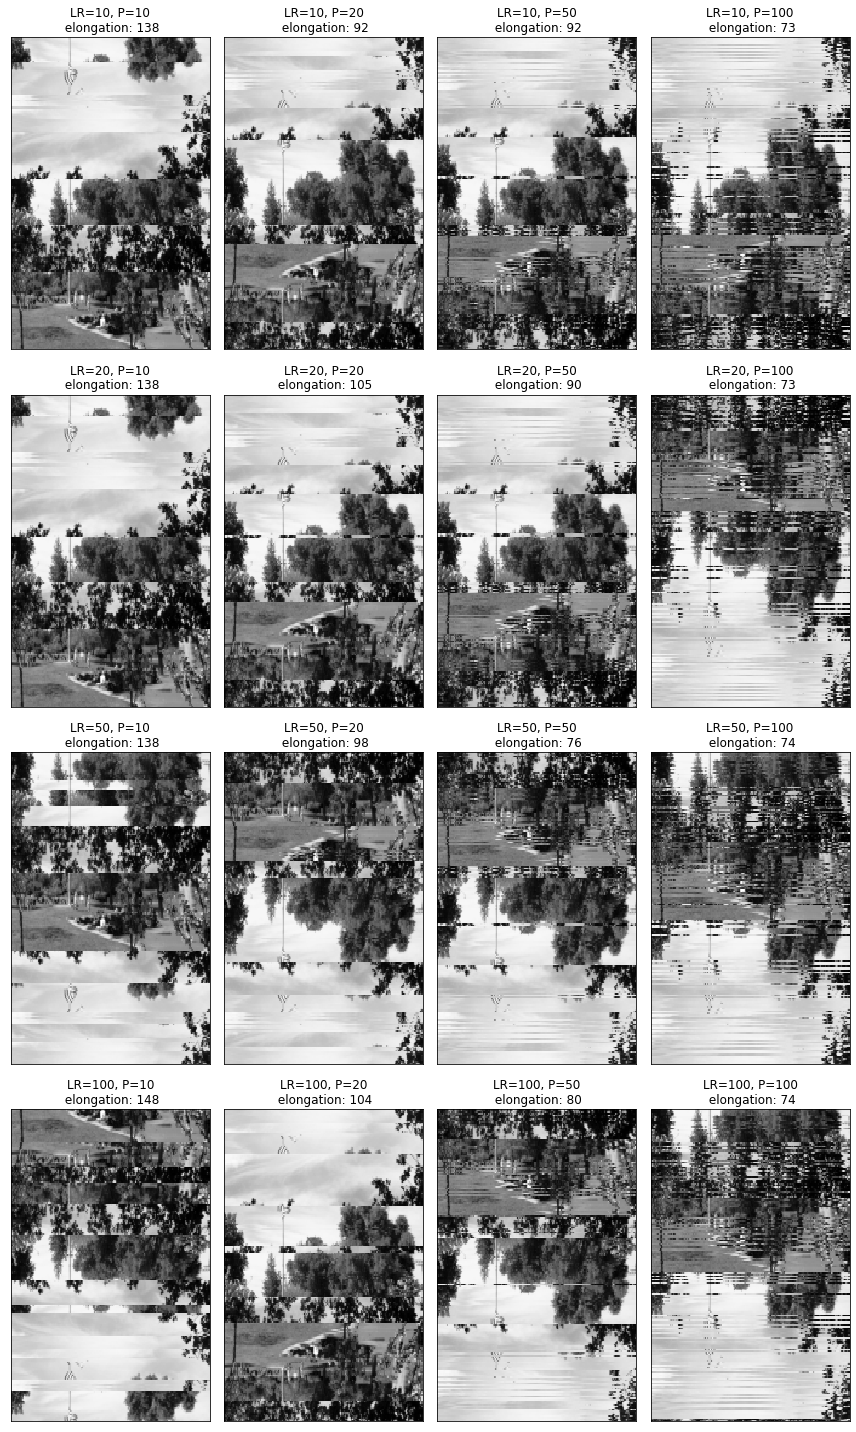

In [16]:
learning_rate_list = [10, 20, 50, 100]
perplexity_list = [10, 20, 50, 100]

plt.figure(1, figsize=(3*4, 5*4))

for i, learning_rate_value in enumerate(learning_rate_list):
    for j, perplexity_value in enumerate(perplexity_list):

        # 1D embedding by tSNE, for the sequence
        tsne = TSNE(n_components=1, init='random', random_state=0, 
                    perplexity=perplexity_value, learning_rate=learning_rate_value)
        y = tsne.fit_transform(objects_list_shuffled).flatten()
        sequence = numpy.argsort(y)

        # 2D embedding by tSNE, for the elongation score
        tsne2 = TSNE(n_components=2, init='random', random_state=0, 
                    perplexity=perplexity_value, learning_rate=learning_rate_value)
        y2 = tsne2.fit_transform(objects_list_shuffled)
        normalized_elongation = return_elongation_of_2D_embedding(y2)
        elongation = normalized_elongation * len(y)
        
        # reorder the shuffled dataset and print the elongation
        objects_list_reordered = objects_list_shuffled[sequence, :]
        
        plt.subplot(4, 4, 4*i + j + 1)
        plt.title("LR=%s, P=%s\n elongation: %s" % (learning_rate_value, perplexity_value,
                                                    int(elongation)))
        plt.pcolormesh(objects_list_reordered[::-1], cmap="Greys_r")
        plt.xticks([])
        plt.yticks([])
        
plt.tight_layout()

### UMAP
Apply UMAP to the shuffled image. Examine several different choices of hyper-parameters. For each choice, estimate the elongation of the resulting embedding, and print it next to the result. 

/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/anaconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/anaconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back fro

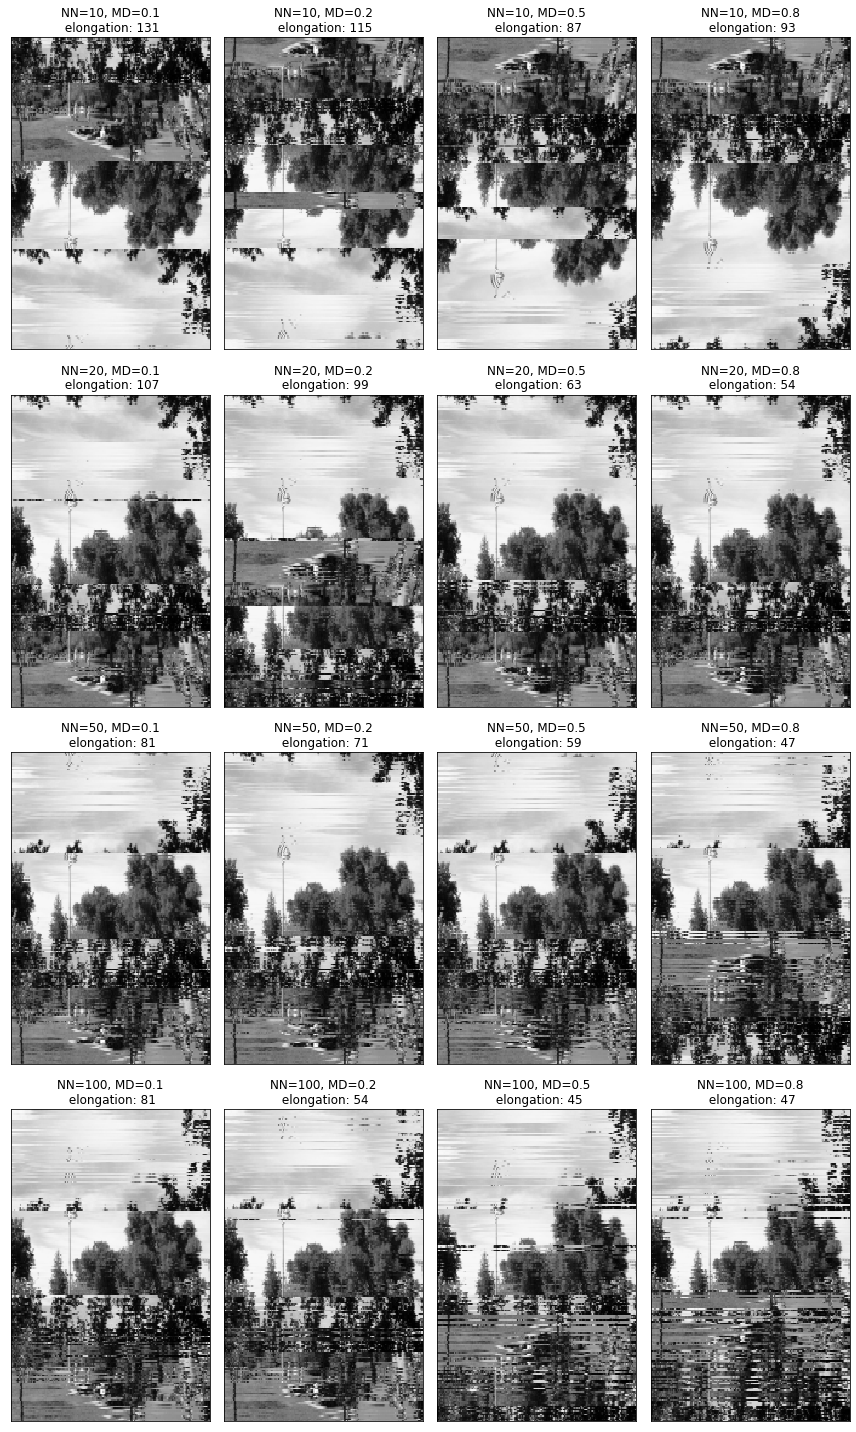

In [17]:
n_neighbor_list = [10, 20, 50, 100]
min_dist_list = [0.1, 0.2, 0.5, 0.8]

plt.figure(1, figsize=(3*4, 5*4))

for i, n_neighbor_value in enumerate(n_neighbor_list):
    for j, min_dist_value in enumerate(min_dist_list):

        # 1D embedding by UMAP, for the sequence
        reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                            min_dist=min_dist_value, n_components=1)
        y = reducer.fit_transform(objects_list_shuffled).flatten()
        sequence = numpy.argsort(y)

        # 2D embedding by UMAP, for the elongation score
        reducer2 = umap.UMAP(random_state=42, n_neighbors=n_neighbor_value, 
                             min_dist=min_dist_value, n_components=2)
        y2 = reducer2.fit_transform(objects_list_shuffled)
        normalized_elongation = return_elongation_of_2D_embedding(y2)
        elongation = normalized_elongation * len(y)
        
        # reorder the shuffled dataset and print the elongation
        objects_list_reordered = objects_list_shuffled[sequence, :]
        
        plt.subplot(4, 4, 4*i + j + 1)
        plt.title("NN=%s, MD=%s\n elongation: %s" % (n_neighbor_value, min_dist_value,
                                                    int(elongation)))
        plt.pcolormesh(objects_list_reordered[::-1], cmap="Greys_r")
        plt.xticks([])
        plt.yticks([])
        
plt.tight_layout()

### Summary:
One can see that the resulting embedding by tSNE/UMAP critically depends on the hyper-parameters of the algorithms. The elongation of the one-dimensional embedding can be used as a figure of merit with which the hyper-parameters can be optimized. The examples shown above suggest that we reach better reconstructions of the natural images when the elongation is larger. The notebook `comparison_with_tsne_and_umap.ipynb` contains functions that take a dataset as an input, and return the "best" one-dimensional embedding by tSNE/UMAP, where "best" is defined as the result with the largest elongation. 